In [9]:
import numpy as np
from exploration.config import sql_inst, mongo_inst

In [37]:
 val_random_db = mongo_inst['val_random_db']
 val_dump = (val_random_db['osu_scores_high'], val_random_db['osu_user_stats'])

In [84]:
pdf_func = np.load("exploration/skill_biased_sampling_function/pdf_sample_func.npy")
greedy_func = np.load("exploration/skill_biased_sampling_function/greedy_sample_func.npy")

In [141]:
values = list(enumerate(_func))

In [142]:
with sql_inst('osu_random_2021_02') as conn:
    with conn.cursor() as cursor:
        cursor.execute(
            '''
            DROP TABLE IF EXISTS sample_func;
            CREATE TABLE sample_func  (user_pp INT PRIMARY KEY, probability FLOAT NOT NULL);
            ALTER TABLE sample_func AUTO_INCREMENT=100;
            '''
        )
    conn.commit()

    with conn.cursor() as cursor:
        cursor.executemany(
            '''
            INSERT INTO sample_func VALUES
            (%s, %s)
            '''
        , values)
    conn.commit()

In [25]:
from datetime import datetime
from mlpp.data_collection.sample_func import sampleFuncGenerator

with sql_inst('osu_random_2021_02') as conn:
    with conn.cursor() as cursor:
        cursor.execute(
            '''
            SELECT * FROM osu_user_stats
            WHERE rank_score < 7000 AND RAND() <= (
                SELECT probability FROM sample_func
                WHERE user_pp = FLOOR(rank_score)
                LIMIT 1
            )
            '''
        )

        sampled_users = [u[0] for u in cursor]
        print(sampled_users)

        sampled_scores = list(
            mongo_inst['val_random_db']['osu_scores_high'].find({
                'user_id': {
                    '$in': sampled_users
                },
                'date': {
                    '$gt': datetime(2019, 1, 1)
                }
            }, {'mlpp.est_user_pp': 1})
        )

        data = list(map(lambda s: s['mlpp']['est_user_pp'],sampled_scores))

        print(sampleFuncGenerator.prop_displaced(data))
    

[809236, 2033331, 2818878, 3011825, 3246964, 3395616, 4733339, 5312460, 6157740, 6403191, 6893278, 7017266, 7144619, 7258388, 7373672, 7382408, 7658476, 7810711, 7892417, 8399142, 8579200, 8624460, 9056927, 9139905, 9426645, 9698697, 9807224, 9945025, 11089802, 11222674, 11238436, 11428584, 11475111, 11695032, 12431776, 12741052, 12913393, 13088399, 13126452, 13388739, 14452584, 14489553, 15201821, 15314997, 15620087, 15685251, 15734644, 15749123, 15808959, 15871019, 16027876, 16194198, 16705118, 17144095, 17646627, 17657868, 17770357, 18293437, 18991713, 19269758, 19487079, 19837951, 20197189]
0.16783492691504562


In [31]:
NUM_BINS = 200
MAX_PP = 7000
DATE_LIMIT = datetime(2019,1,1)

generator = sampleFuncGenerator(date_limit = DATE_LIMIT, max_pp = MAX_PP, n_bins = NUM_BINS)

In [32]:
def simulate_fit(fit, dump = osu_dump):
    sc, _ = generator.simulate(*dump, fit)
    score_pp = list(map(lambda s: s['mlpp']['est_user_pp'], sc))
    return score_pp

In [130]:
sample = simulate_fit(greedy_func, val_dump)
cap = len(sample) / 50

In [140]:
len(sample)/ val_dump[0].count()

0.016210646881881945

In [132]:
users_7k_up = [u['_id'] for u in val_dump[1].find({'rank_score': {'$gt': 7000}}, {'_id': 1})]

In [133]:
random_scores_pipeline = [
    {'$match': {
        'date': {'$gt': datetime(2019, 1, 1)},
        'user_id': {'$nin': users_7k_up}
    }},
    {'$sample': {'size': len(sample)}},
    {'$project': {'mlpp': {'est_user_pp': 1}}}
]

In [134]:
random_sample = [s['mlpp']['est_user_pp'] for s in val_dump[0].aggregate(random_scores_pipeline)]

In [138]:
sampleFuncGenerator.prop_displaced(sample)

0.12398501398343097

[Text(0.5, 0, 'Score est user PP'), Text(0, 0.5, 'Count')]

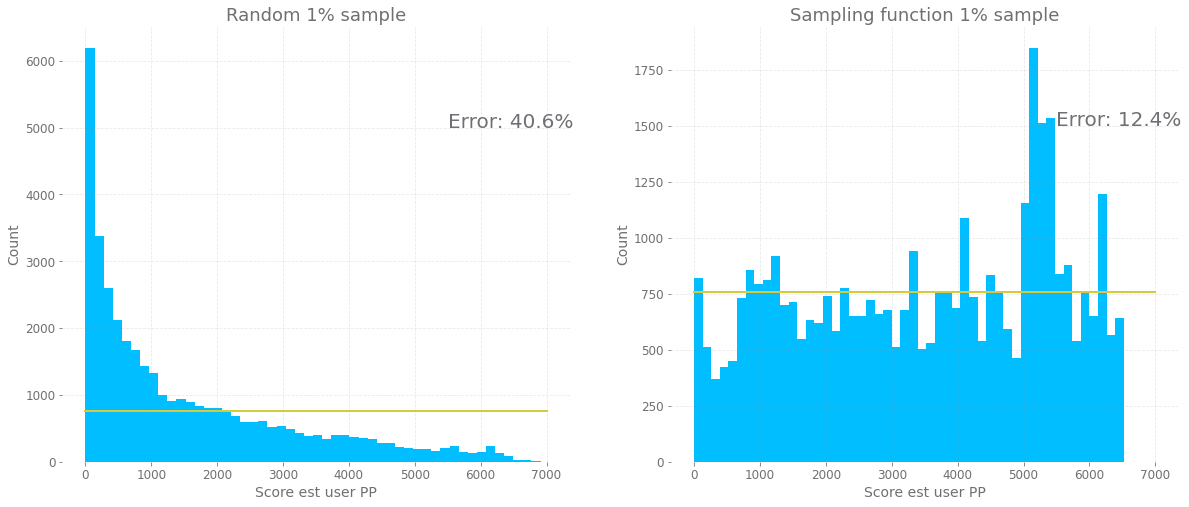

In [139]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize = (20, 8))
axs[0].hist(random_sample, bins = 50)
axs[0].plot([0, 7000], [cap, cap])
axs[0].set_title('Random 1% sample')
axs[0].annotate(f'Error: 40.6%', [5500, 5000], fontsize=20)
axs[0].set(xlabel = 'Score est user PP', ylabel='Count')
axs[1].hist(sample, bins = 50)
axs[1].plot([0, 7000], [cap, cap])
axs[1].annotate(f'Error: 12.4%', [5500, 1500], fontsize=20)
axs[1].set_title('Sampling function 1% sample')
axs[1].set(xlabel = 'Score est user PP', ylabel='Count')